In [1]:
import os
import yaml
import pickle
from scipy import stats  
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt

from copy import deepcopy
from sklearn.linear_model import Lasso, LinearRegression, Ridge, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

alt.data_transformers.disable_max_rows()
alt.renderers.enable('mimetype');

### Prepare Data

In [2]:
with open("config.yaml", "r") as config_file:
    config = yaml.full_load(config_file)
    data_path = config["data_path"]
    models_path = config["models_path"]

In [3]:
adspend_df = pd.read_csv(os.path.join(data_path, "preprocessed_data.csv"))
adspend_df["dt"] = pd.to_datetime(adspend_df["dt"])
adspend_df.head(3)

,dt,inventory,units,adspend,rank
0,2017-09-26,693,36,83.79,51432
1,2017-09-27,673,34,67.16,48596
2,2017-09-28,626,33,50.49,43191


In [4]:
def create_lag_df(ts, lags, zero_lag=True):
    df = pd.DataFrame({f"{ts.name}_lag0": ts})
    
    for lag in range(1, lags + 1):
        df[f"{ts.name}_lag{lag}"] = ts.shift(lag)
    
    if not zero_lag:
        df.drop(f"{ts.name}_lag0", axis=1, inplace=True)
    return df

In [5]:
adspend_lags = 1
units_lags = 1

In [6]:
max_lag = max(adspend_lags, units_lags)

x = pd.concat((create_lag_df(adspend_df["units"], units_lags, zero_lag=False),
               create_lag_df(adspend_df["adspend"], adspend_lags, zero_lag=False)), axis=1)
y = adspend_df["adspend"]

x, y = x.iloc[max_lag:], y.iloc[max_lag:]
print(x.shape, y.shape)
x.head(3)

(1057, 2) (1057,)


,units_lag1,adspend_lag1
1,36.0,83.79
2,34.0,67.16
3,33.0,50.49


In [7]:
test_set_size = 90
x_train, x_test, y_train, y_test = x.iloc[: -test_set_size], x.iloc[-test_set_size:], y.iloc[: -test_set_size], y.iloc[-test_set_size:]

### EDA

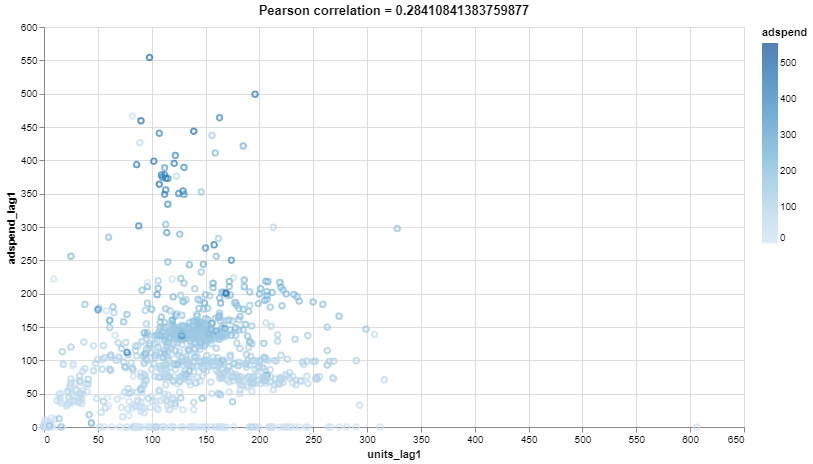

In [8]:
alt.Chart(pd.concat((x, y), axis=1)).mark_point(point=True) \
.encode(
    x = alt.X("units_lag1:Q"),
    y = alt.Y("adspend_lag1:Q"),
    color = alt.Color("adspend:Q")
).properties(width=700, height=400, title=f"Pearson correlation = {x['units_lag1'].corr(x['adspend_lag1'])}")

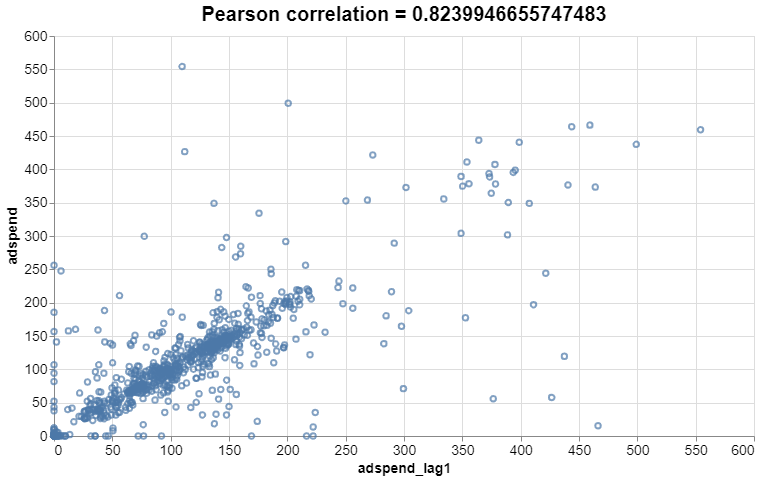

In [9]:
alt.Chart(pd.concat((x, y), axis=1)).mark_point(point=True) \
.encode(
    x = alt.X("adspend_lag1:Q"),
    y = alt.Y("adspend:Q"),
).properties(width=700, height=400, title=f"Pearson correlation = {y.corr(x['adspend_lag1'])}").configure_axis(
    labelFontSize=14,
    titleFontSize=14
).configure_title(fontSize=20)

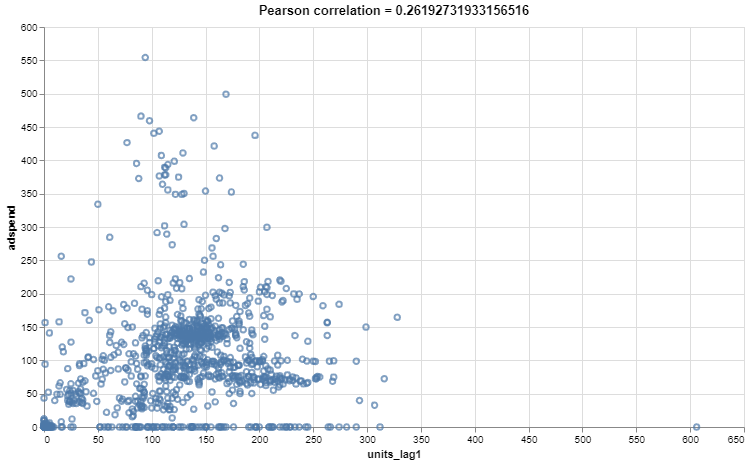

In [10]:
alt.Chart(pd.concat((x, y), axis=1)).mark_point(point=True) \
.encode(
    x = alt.X("units_lag1:Q"),
    y = alt.Y("adspend:Q"),
).properties(width=700, height=400, title=f"Pearson correlation = {x['units_lag1'].corr(y)}")

In [11]:
linear_model = LinearRegression()
linear_model.fit(x[["adspend_lag1"]], y)
residuals = y - linear_model.predict(x[["adspend_lag1"]])
residuals.name = "residuals"

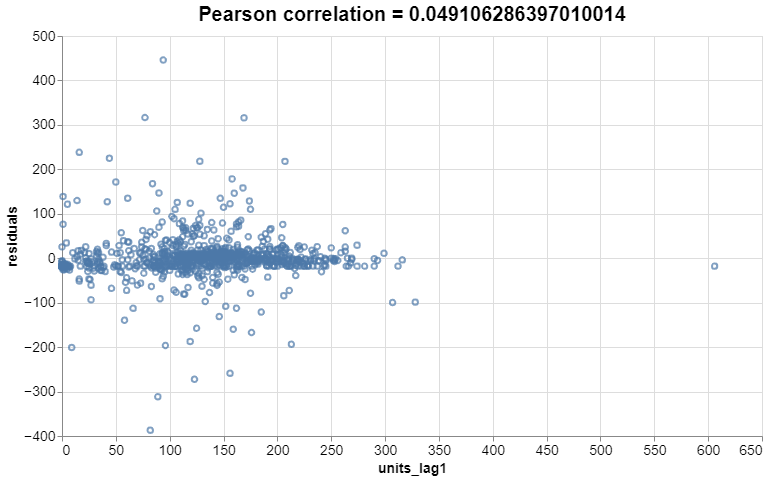

In [13]:
alt.Chart(pd.concat((x, residuals), axis=1)).mark_point(point=True) \
.encode(
    x = alt.X("units_lag1:Q"),
    y = alt.Y("residuals:Q"),
).properties(width=700, height=400, title=f"Pearson correlation = {x['units_lag1'].corr(residuals)}").configure_axis(
    labelFontSize=14,
    titleFontSize=14
).configure_title(fontSize=20)

### Save models 

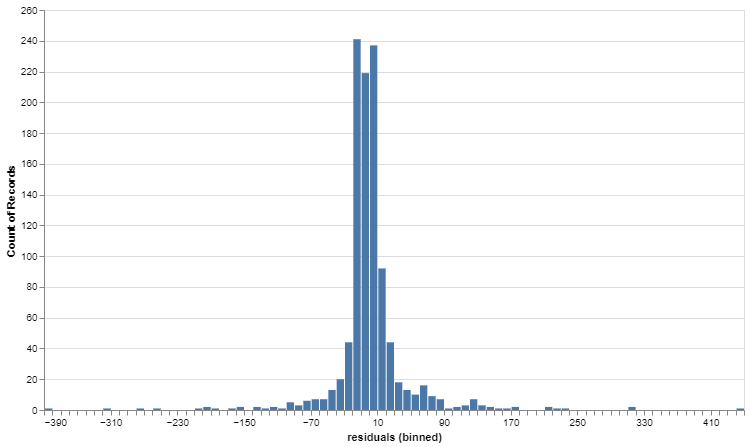

In [14]:
histogram = alt.Chart(pd.concat((x, residuals), axis=1)).mark_bar(point=True) \
.encode(
    x = alt.X("residuals:Q", bin=alt.Bin(maxbins=100)),
    y = alt.Y("count()"),
).properties(width=700, height=400)

histogram

In [21]:
pickle.dump(linear_model, open(os.path.join(models_path, "adspend_forecasting_model.pkl"), "wb"))

In [15]:
stat, p = stats.shapiro(residuals)
print(f"Statistics = {stat}, p = {p}")

alpha = 0.01
if p > alpha:
    print("Sample looks Gaussian (fail to reject H0)")
else:
    print("Sample does not look Gaussian (reject H0)")

Statistics = 0.6859253644943237, p = 2.199926485112817e-40
Sample does not look Gaussian (reject H0)


In [16]:
mu, b = stats.laplace.fit(residuals)
print(f"mu = {mu}; b = {b}")

mu = -2.4315288890291527; b = 23.719429814962446


In [36]:
np.save(os.path.join(models_path, "adspend_residuals_parameters.npy"), np.array([mu, b]))

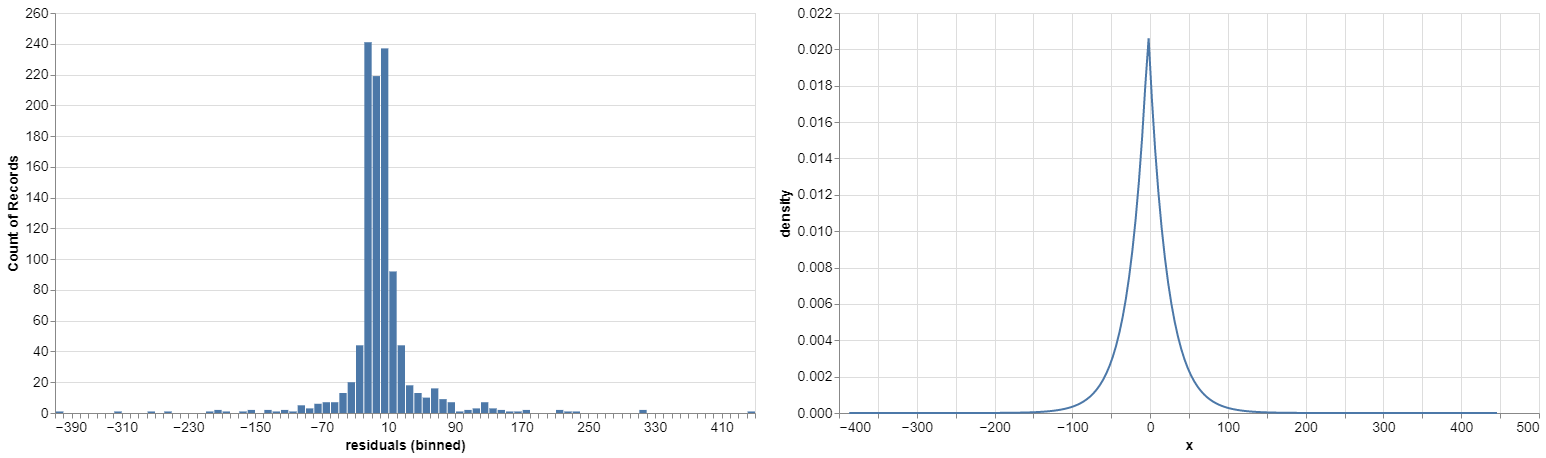

In [17]:
xt = np.linspace(residuals.min(), residuals.max(), 200)
density = stats.laplace.pdf(xt, mu, b)

density_chart = alt.Chart(pd.DataFrame({"x": xt, "density": density})).mark_line() \
.encode(
    x = alt.X("x:Q"),
    y = alt.Y("density:Q"),
).properties(width=700, height=400)

alt.ConcatChart(concat=[histogram, density_chart]).configure_axis(
    labelFontSize=14,
    titleFontSize=14
).configure_title(fontSize=20)